In [1]:
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import wandb
#wandb.init()
#from Model.network import Net

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 80, kernel_size = 5)
        self.conv2 = nn.Conv2d(80, 80, kernel_size = 5)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.batch_norm1 = nn.BatchNorm2d(80)
        self.batch_norm2 = nn.BatchNorm2d(80)

        self.fc1 = nn.Linear(1280, 250)
        self.fc2 = nn.Linear(250, 25)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x

In [3]:
class SignsLanguageDataset(Dataset):

    def __init__(self, data):

        self.signs_lang_dataset = data
        self.X_set = self.signs_lang_dataset.iloc[:, 1:].values
        self.y_set = self.signs_lang_dataset.iloc[:, 0].values

        self.X_set = np.reshape(self.X_set, (self.X_set.shape[0], 1, 28, 28)) / 255
        self.y_set = np.array(self.y_set)

    def __getitem__(self, index):

        image = self.X_set[index, :, :]

        label = self.y_set[index]

        sample = {'image_sign': image, 'label': label}

        return sample

    def __len__(self):
        return self.X_set.__len__()


def train(model, optimizer, epoch, device, train_loader, log_interval):
 
    model.train()
    for batch_idx, data in enumerate(train_loader):

        img = data['image_sign']
        img = img.type(torch.FloatTensor).to(device)
        target = data['label']
        target = target.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        output = model(img)
        loss = F.nll_loss(output, target)

        loss.backward()
        optimizer.step()
        wandb.log({ "train loss": loss})
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
        

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            img = data['image_sign']
            img = img.type(torch.FloatTensor).to(device)
            target = data['label']
            target = target.type(torch.LongTensor).to(device)

            output = model(img)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    print('\nValiation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    wandb.log({"validation loss": test_loss, "validation accuracy" : test_acc })

signmnist_train = pd.read_csv(r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/Data/sign_mnist_train.csv")
signmnist_test = pd.read_csv(r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/Data/sign_mnist_test.csv")
train_data, val_data = np.split(signmnist_train.sample(frac=1, random_state=42), [int(0.8 * len(signmnist_train))])
dataset_train = SignsLanguageDataset(train_data)
dataset_val = SignsLanguageDataset(val_data)
train_loader = DataLoader(dataset = dataset_train, batch_size = 32,shuffle=True)
val_loader = DataLoader(dataset = dataset_val, batch_size = 32,shuffle=False)

/home/cassanova/miniconda3/envs/signlanguage/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [4]:


device = 'cuda'



#torch.manual_seed(123)

learning_rate = 3e-2
num_epochs = 48
model = Net()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.2, weight_decay = 0.002)
log_interval = 120
run = wandb.init(
project="SignlanguageCNN",    # Specify your project
config={                         # Track hyperparameters and metadata
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    },
)
for epoch in range(1, num_epochs + 1):

    train(model, optimizer, epoch, device, train_loader, log_interval)
    test(model, device, val_loader)

torch.save(model.state_dict(), r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/weights/model_CNN_submission")

wandb: Currently logged in as: kingconcentrer (kingconcentrer-1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Train Epoch: 1 [0/21964 (0%)]	Loss: 3.284498
Train Epoch: 1 [3840/21964 (17%)]	Loss: 0.558906
Train Epoch: 1 [7680/21964 (35%)]	Loss: 0.155683
Train Epoch: 1 [11520/21964 (52%)]	Loss: 0.080028
Train Epoch: 1 [15360/21964 (70%)]	Loss: 0.042758
Train Epoch: 1 [19200/21964 (87%)]	Loss: 0.025565

Valiation set: Average loss: 0.0006, Accuracy: 5491/5491 (100%)

Train Epoch: 2 [0/21964 (0%)]	Loss: 0.019587
Train Epoch: 2 [3840/21964 (17%)]	Loss: 0.013711
Train Epoch: 2 [7680/21964 (35%)]	Loss: 0.011508
Train Epoch: 2 [11520/21964 (52%)]	Loss: 0.010709
Train Epoch: 2 [15360/21964 (70%)]	Loss: 0.010514
Train Epoch: 2 [19200/21964 (87%)]	Loss: 0.010381

Valiation set: Average loss: 0.0003, Accuracy: 5491/5491 (100%)

Train Epoch: 3 [0/21964 (0%)]	Loss: 0.009186
Train Epoch: 3 [3840/21964 (17%)]	Loss: 0.009294
Train Epoch: 3 [7680/21964 (35%)]	Loss: 0.004906
Train Epoch: 3 [11520/21964 (52%)]	Loss: 0.004597
Train Epoch: 3 [15360/21964 (70%)]	Loss: 0.009658
Train Epoch: 3 [19200/21964 (87%)]	Loss

In [5]:
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import torch

data = signmnist_test.iloc[:,1:].values.reshape(signmnist_test.shape[0],1,28,28)
data = torch.Tensor(data).to(device)
y_true = signmnist_test.iloc[:,0].values.reshape(signmnist_test.shape[0],1).squeeze()
y_pred_tensor = model(data)
y_pred = y_pred_tensor.cpu().detach().numpy()
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       331
           1       0.92      0.94      0.93       432
           2       0.85      0.94      0.89       310
           3       1.00      0.85      0.92       245
           4       1.00      0.90      0.95       498
           5       1.00      0.66      0.80       247
           6       0.93      0.79      0.86       348
           7       1.00      0.93      0.96       436
           8       1.00      0.31      0.47       288
          10       1.00      0.75      0.86       331
          11       1.00      0.62      0.77       209
          12       0.90      0.74      0.81       394
          13       0.95      0.77      0.85       291
          14       0.56      1.00      0.72       246
          15       1.00      0.38      0.55       347
          16       0.15      1.00      0.27       164
          17       0.86      0.84      0.85       144
          18       0.48    

<Axes: >

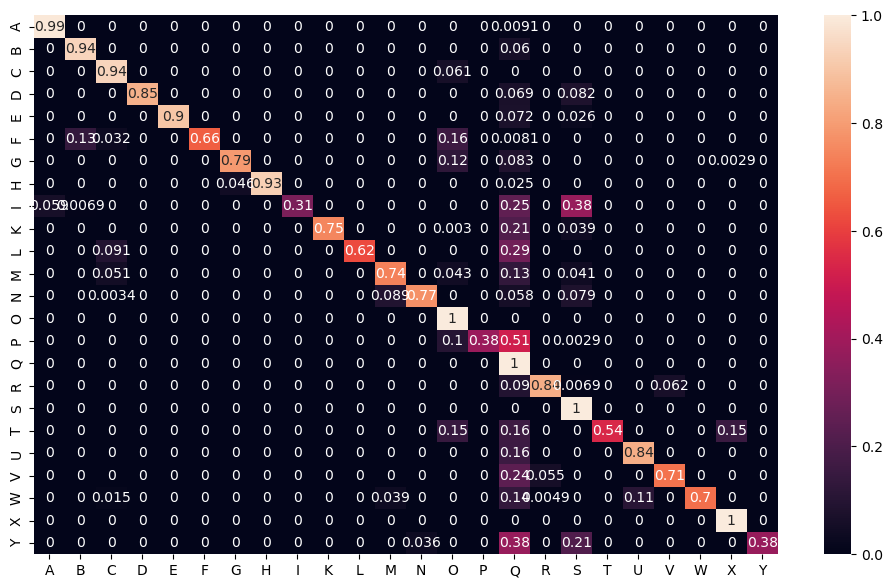

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Build confusion matrix
signs = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F',
         '6': 'G', '7': 'H', '8': 'I', '10': 'K', '11': 'L', '12': 'M',
         '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R', '18': 'S',
         '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y' }
lst = signs.values()
lst = list(lst)
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in lst],
                        columns=[i for i in lst])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)


In [7]:
# import numpy as np
# import cv2
# import torch

# #from Model.network import Net

# cap = cv2.VideoCapture(0)

# cap.set(3, 700)
# cap.set(4, 480)

# device = "cpu"
# model=Net()
# model.to(device)
# # if torch.cuda.is_available():
# checkpoint = r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/weights/model_CNN_submission"
# checkpoints=torch.load(checkpoint)
# try:
#     checkpoints.eval()
# except AttributeError as error:
#     print(error)

# model.load_state_dict(checkpoints)
# model.eval()

# signs = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', '6': 'G', '7': 'H', '8': 'I',
#         '10': 'K', '11': 'L', '12': 'M', '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R',
#         '18': 'S', '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y' }
# while True:
#     ret, frame = cap.read()
#     img = frame[100:250, 100:250]

#     res = cv2.resize(img, dsize=(28, 28), interpolation = cv2.INTER_CUBIC)
#     res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

#     res1 = np.reshape(res, (1, 1, 28, 28)) / 255
#     res2 = torch.from_numpy(res1)
#     res3 = res2.type(torch.FloatTensor)

#     out = model(res3)

#     probs, label = torch.topk(out, 25)
#     probs = torch.nn.functional.softmax(probs, 1)

#     pred = out.max(1, keepdim=True)[1]

#     if float(probs[0,0]) < 0.4:
#         text = 'Sign not detected!'
#     else:
#         text = signs[str(int(pred))] + ': ' + '{:.2f}'.format(float(probs[0,0])) + '%'

#     font = cv2.FONT_HERSHEY_SIMPLEX
#     frame = cv2.putText(frame, text, (60,285), font, 1, (255,0,0), 2, cv2.LINE_AA)

#     frame = cv2.rectangle(frame, (20, 20), (250, 250), (0, 255, 0), 3)

#     cv2.imshow('Cam', frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
    
# cap.release()
# cv2.destroyAllWindows()